# Second empirical example for optimization of enzyme reaction rates

### Popular choices to model the reaction rate in dependency of T
#### 1. Ratkowksy model up to $T_{opt}$ and Gaussian model from there

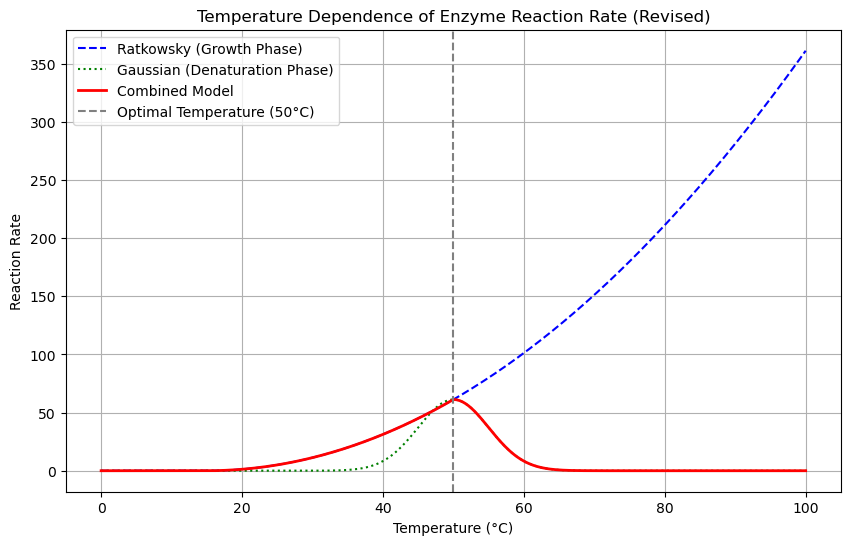

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Temperature range
T = np.linspace(0, 100, 500)  # Temperature range (0-100°C)

# Ratkowsky equation parameters
T_min = 15   # Minimum temperature for activity
b = 0.05    # Growth constant

# Gaussian model parameters
T_opt = 50  # Optimal temperature
sigma = 5  # Spread of the Gaussian

# Compute the Ratkowsky curve (valid for T > T_min)
ratkowsky_curve = np.where(T > T_min, b * (T - T_min)**2, 0)

# Determine the Gaussian scale at the transition point
r_opt = b * (T_opt - T_min)**2  # Value of Ratkowsky curve at T_opt

# Compute the Gaussian curve (scaled to match Ratkowsky at T_opt)
gaussian_curve = r_opt * np.exp(-(T - T_opt)**2 / (2 * sigma**2))

# Combine the two for an empirical bell-shaped curve
combined_curve = np.where(T < T_opt, ratkowsky_curve, gaussian_curve)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(T, ratkowsky_curve, label="Ratkowsky (Growth Phase)", linestyle="--", color="blue")
plt.plot(T, gaussian_curve, label="Gaussian (Denaturation Phase)", linestyle=":", color="green")
plt.plot(T, combined_curve, label="Combined Model", linewidth=2, color="red")
plt.axvline(T_opt, color="gray", linestyle="--", label=f"Optimal Temperature ({T_opt}°C)")

plt.title("Temperature Dependence of Enzyme Reaction Rate (Revised)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()

#### 2. Alternative: Extended Ratkowsky model

$k = b * \left(T - T_\mathrm{min}\right)^2 \cdot \left(1 - e^{c \cdot (T - T_\mathrm{max})}\right),$ 

$k=0$ for $T>T_\mathrm{max}$ or $T<T_\mathrm{min}$


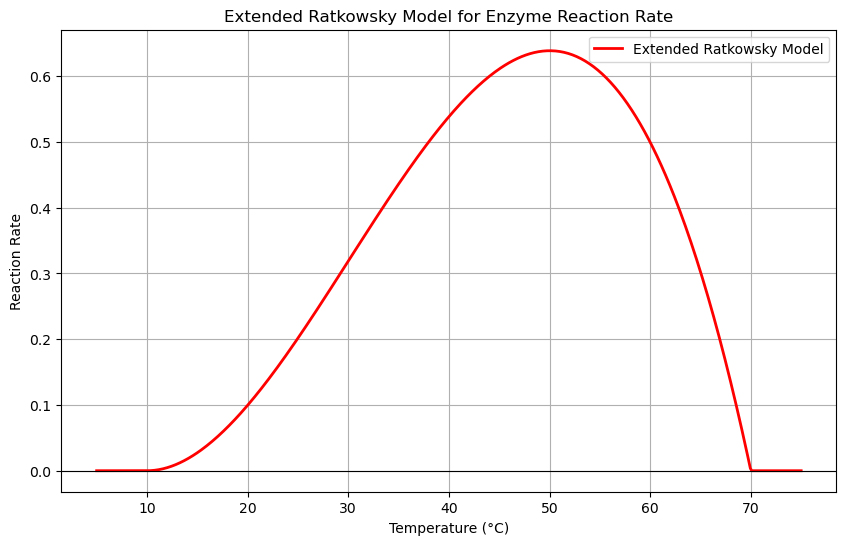

In [2]:
import matplotlib.pyplot as plt

from kinetics import ratkowsky_curve

# Plotting the Ratkowsky curve over a temperature range
T_min = 10    # Minimum temperature for activity
T_max = 70   # Maximum temperature (activity zero greater or equal to this)
T = np.linspace(T_min-5, T_max+5, 500)  # Temperature range between 5 and T_max
b = 0.1   # Growth constant
c = 0.0002    # Decay constant

extended_ratkowsky_curve = ratkowsky_curve(T, T_min=T_min, T_max=T_max, b=b, c=c)

plt.figure(figsize=(10, 6))
plt.plot(T, extended_ratkowsky_curve, label="Extended Ratkowsky Model", color="red", linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Extended Ratkowsky Model for Enzyme Reaction Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()


In the following, we will be working with the extended Ratkowsky model to generate the ground truth for reaction rates at different temperatures.

## Case study: Optimization of reaction rates

The kinetics of the enzyme follow a first-order model. The reaction rate is dependent on the temperature according to the extended Ratkowksy model, which is however unknown beforehand. Let's see step-by-step how we can retrieve the optimal temperature from experiments.

### Step 1: Generate mock data.
Generate data from two batch experiments, each having three measurements (e.g. shake flaks in incubators at different temperatures). Let's first not assume batch effects (i.e. systematic bias in measurement occuring between the two batch experiments).

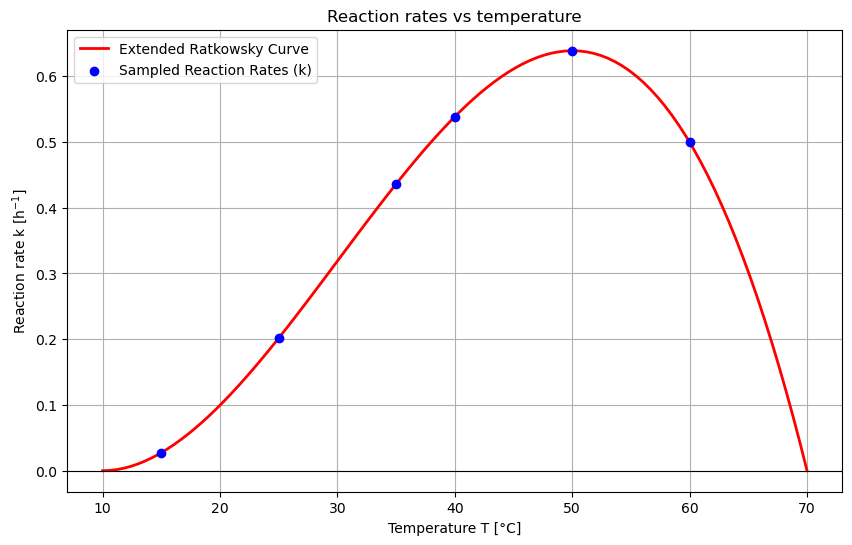

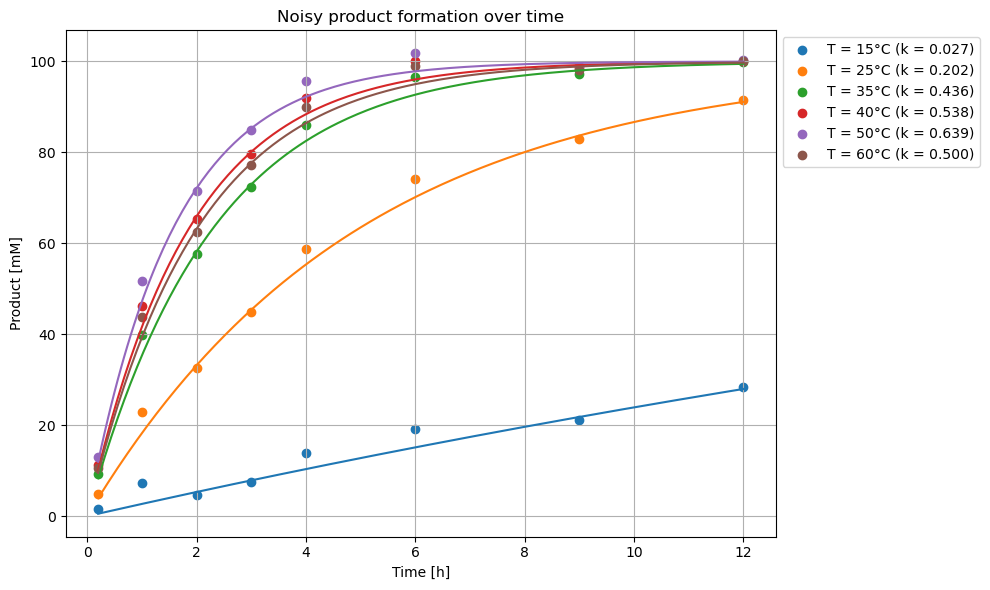

In [3]:
from utils import extract_high_res_P_series, get_P_samples


# Fixed sampled temperatures (°C)
T_sampled = np.array([15, 25, 35, 40, 50, 60])

# Compute reaction rates (k) for sampled temperatures
reaction_rates = ratkowsky_curve(T_sampled, T_min=T_min, T_max=T_max, b=b, c=c)

# Generate the full dependency curve of k on T for plotting
T_full = np.linspace(T_min, T_max, 100)  # Fine-grained temperature range for the curve
k_full = ratkowsky_curve(T_full, T_min=T_min, T_max=T_max, b=b, c=c)

# Time sampling
time = np.array([0.2, 1, 2, 3, 4, 6, 9, 12])

# Initial substrate concentration (mM)
S0 = 100

# Compute product formation (P) over time for each temperature and reaction rate
P_samples = {}
for i, rate in enumerate(reaction_rates):
    P_noisy = get_P_samples(
        k=rate,
        S0=100,
        time=time,
        seed=20241125+1, # set a seed
    )
    P_samples[rate] = P_noisy


# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, reaction_rates, color="blue", label="Sampled Reaction Rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for i, k in enumerate(P_samples.keys()):
    P_noisy = P_samples[k]
    plt.scatter(time, P_noisy, marker="o", label=f"T = {T_sampled[i]}°C (k = {reaction_rates[i]:.3f})")
    plt.plot(*(extract_high_res_P_series(time, k)))

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()


### Step 2: Prepare the data as a numpy array with shape (catalyst, time points)

In [4]:
observed = []
for tseries in P_samples.values():
    observed.append(list(tseries))
observed = np.array(observed)
print(observed.shape)

(6, 8)


### Step 3: Build the PyMC model

In [5]:
import pymc as pm
import pytensor.tensor as pt

# Coordinates help us to keep track of the different data dimensions
coords = {
    "catalyst": np.arange(6),
    "time": time,
}

with pm.Model(coords=coords) as pmodel:
    # First, let's add the observed data to the model
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    # We then add a prior for the substrate, which we expect to be around a known concentration (plus pipetting error)
    S_0 = pm.Normal("S0", mu=100, sigma=5)
    # We then set up the parameters for the Gaussian process (GP)
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)

    # The reaction rate cannot be observed directly, so we use a latent GP
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_t", X=T_sampled[:, None], jitter=1e-4)

    # Finally, we can bring all parameters together in the first-order reaction
    # We thus have a hybrid model (mechanistic equation and GP for k)
    P = pm.Deterministic("P", S_0 * (1 - pt.exp(-k[:, None] * time[None, :])), dims=("catalyst", "time"))

    # In the likelihood, the modeled P is compared with the observations
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed,
        dims=("catalyst", "time")
    )
    trace = pm.sample(5000, tune=1000, chains=8, cores=-1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, k_over_t_rotated_]


Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 12 seconds.


### Step 4: Analyze the model

#### Trace plot

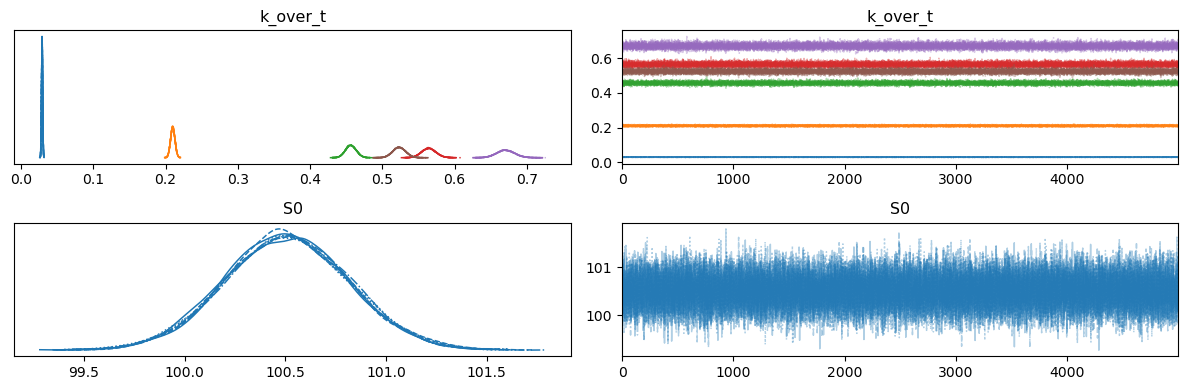

In [6]:
from matplotlib import pyplot as plt
pm.plot_trace(trace, var_names=["k_over_t", "S0"])
plt.tight_layout()

#### Posterior for GP

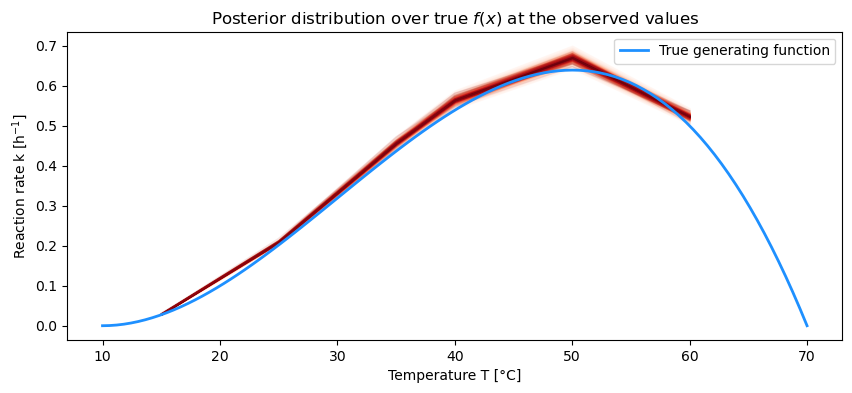

In [7]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
import arviz as az

f_post = az.extract(trace, var_names="k_over_t").transpose("sample", ...)
plot_gp_dist(ax, f_post, T_sampled[:, None])


# plot the data and the true latent function
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

#### Compute posterior predictive, which can also be used for further Bayesian optimization

In [8]:
with pmodel:
    # add the GP conditional to the model, given the new X values
    f_pred = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace.extend(pm.sample_posterior_predictive(trace, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

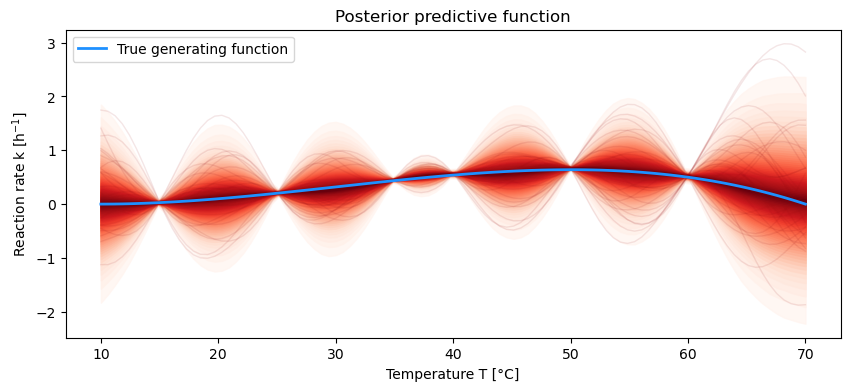

In [9]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred = az.extract(trace.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

### Conclusions
This case study shows how the combination of kinetics and a latent Gaussian process can be used to model the relationship between reaction rate and temperature from observed kinetic data. So far, we could model our data well using the combination of a mechanistic model (first-order reaction) and a GP describing the reaction rate. Let's see if this is also possible for more complex process data. To simulate this, we add a batch effect to the experimental data.

## Introduction of Batch effect
### Step 1: Generate more complex data

In [10]:
import pandas as pd
shakers = [1, 2, 3, 1, 4, 2, 3, 4]
batches = [1, 1, 1, 2, 1, 2, 2, 2]
df = pd.DataFrame([], columns=["time", "batch", "device", "P_noisy", "S0", "k_true", "T_true"])
index = 0
T_sampled = np.array([15, 25, 30, 30, 35, 45, 55, 68])
S0_true = [109, 97]
true_rates = []
for i, T_value in enumerate(T_sampled):
    batch = batches[i]
    S0 = S0_true[batch-1]
    k_value = ratkowsky_curve(
        T=T_value,
        T_min=T_min,
        T_max=T_max,
    )
    P_samples = get_P_samples(
        k=float(k_value),
        S0=S0,
        time=time,
        sigma=7,
        seed=2024121 + i, # set seed
    )
    true_rates.append(k_value)
    for j, P_value in enumerate(P_samples):
        index += 1
        df.loc[index] = [
            time[j],
            batch,
            shakers[i],
            P_value,
            S0,
            k_value,
            T_value
        ]
df.set_index(["device", "batch"], inplace=True)
df



time    P_noisy   S0               k_true  T_true
device batch                                                   
1      1       0.2   5.922414  109  0.02734930306157818      15
       1       1.0   0.000000  109  0.02734930306157818      15
       1       2.0   6.310213  109  0.02734930306157818      15
       1       3.0  10.389730  109  0.02734930306157818      15
       1       4.0  18.384931  109  0.02734930306157818      15
...            ...        ...  ...                  ...     ...
4      2       3.0  30.813144   97   0.1345330915879003      68
       2       4.0  53.344851   97   0.1345330915879003      68
       2       6.0  64.682251   97   0.1345330915879003      68
       2       9.0  75.470721   97   0.1345330915879003      68
       2      12.0  81.654965   97   0.1345330915879003      68

[64 rows x 5 columns]

### Format data as array

In [11]:
print(time.shape)
observed_bias = df.P_noisy.values.reshape((8, time.shape[0]))
print(observed_bias)

(8,)
[[  5.92241418   0.           6.31021269  10.38973017  18.38493058
   12.69413931  17.24532395  29.98885042]
 [  3.8706728   20.34320532  40.89154039  38.37629045  63.95347847
   80.28962243  90.26211294  96.40947938]
 [  0.          41.55608364  57.32911508  80.98694948  81.34337462
   80.67486892  98.4457822  114.7183389 ]
 [  0.          23.50759259  52.03951647  64.37011979  72.54735421
   74.03049579 105.53384678 102.15196113]
 [  8.35251476  44.0031286   67.74537984  73.35743621  88.29813412
   99.54372808 110.99006309 106.67042029]
 [  6.30073611  43.67750627  73.86490851  77.39782681  85.02569214
   94.27101651  94.20327564  93.80605498]
 [ 12.4684604   50.19445048  69.39869206  79.16747074  87.70461855
   93.44888105  98.8824251   98.23874767]
 [  0.           9.15434067  27.33835524  30.81314356  53.34485103
   64.68225069  75.47072111  81.65496466]]


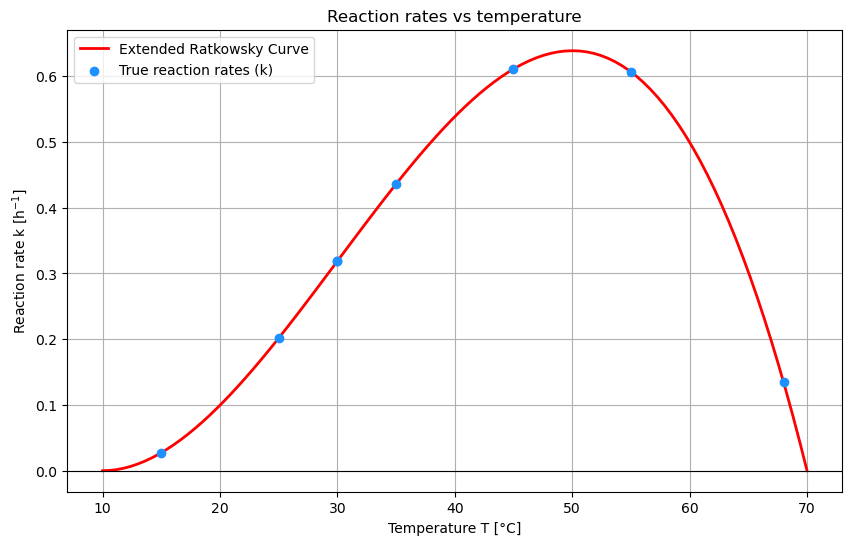

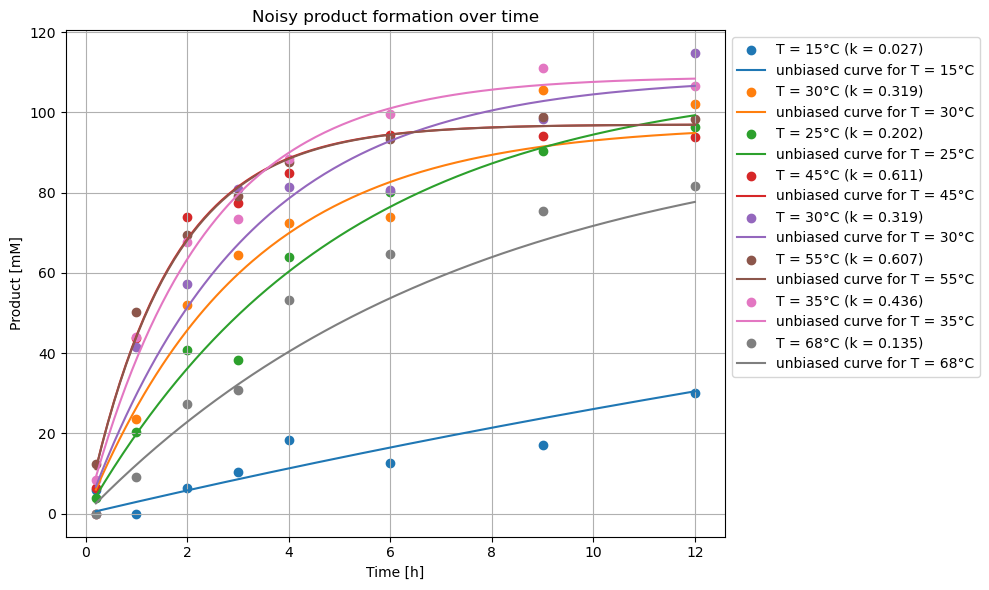

In [12]:
# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for (shaker, batch), data in df.groupby(["device", "batch"]):
    S0 = data.S0.values[0]
    t_data = data.time.values
    P_data = data.P_noisy.values
    k_value = data.k_true.values[0]
    temp = data.T_true.values[0]
    
    plt.scatter(t_data, P_data, marker="o", label=f"T = {temp}°C (k = {k_value:.3f})")
    plt.plot(*(extract_high_res_P_series(
        time=t_data,
        k=k_value,
        S0=S0,
    )), label=f"unbiased curve for T = {temp}°C")

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

The plot above shows how the data is systematically deviating from the expected curves due to the batch effect. Let's see how we can handle this kind of data with a hybrid model.

### Step 2: Build PyMC model with batch effect for substrate

In [13]:
# We add a new dimension for the batch effect
coords = {
    "catalyst": np.arange(8),
    "time": time,
    "batch": [1, 2],
}

with pm.Model(coords=coords) as pmodel2:
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )

    # Here, we again center the substrate prior on the expected concentration
    S_0 = pm.Normal("S0", mu=100, sigma=0.5)
    # However, we add a specific deviation per batch (e.g. different experimentators preparing the solutions)
    S_batch = pm.Normal("S_batch", mu=0, sigma=2, dims="batch")

    # Here, we need to stack the dimensions together in the correct order
    S_catalyst = pm.Deterministic(
        "S_catalyst",
        pt.stack([
            S_0 + S_batch[0],
            S_0 + S_batch[0],
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[1],
            S_0 + S_batch[1],
            ]),
        dims="catalyst"
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_T", X=temp_data[:, None], jitter=1e-4, dims="catalyst")
    
    P = pm.Deterministic("P", S_catalyst[:, None] * (1 - pt.exp(-k[:, None] * timepoints[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed_bias,
        dims=("catalyst", "time")
    )


The computation graph now shows the batch effect.

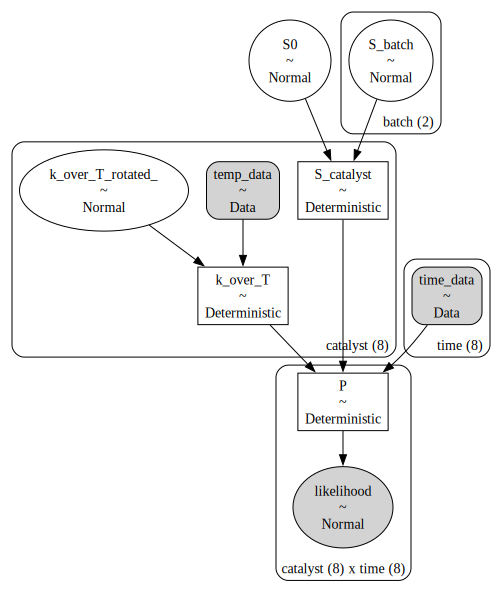

In [14]:
pmodel2.to_graphviz()

In [15]:
with pmodel2:
    trace2 = pm.sample(5000, tune=1000, chains=8, cores=-1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, S_batch, k_over_T_rotated_]


Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 44 seconds.


### Analyze model via diagnostic plots

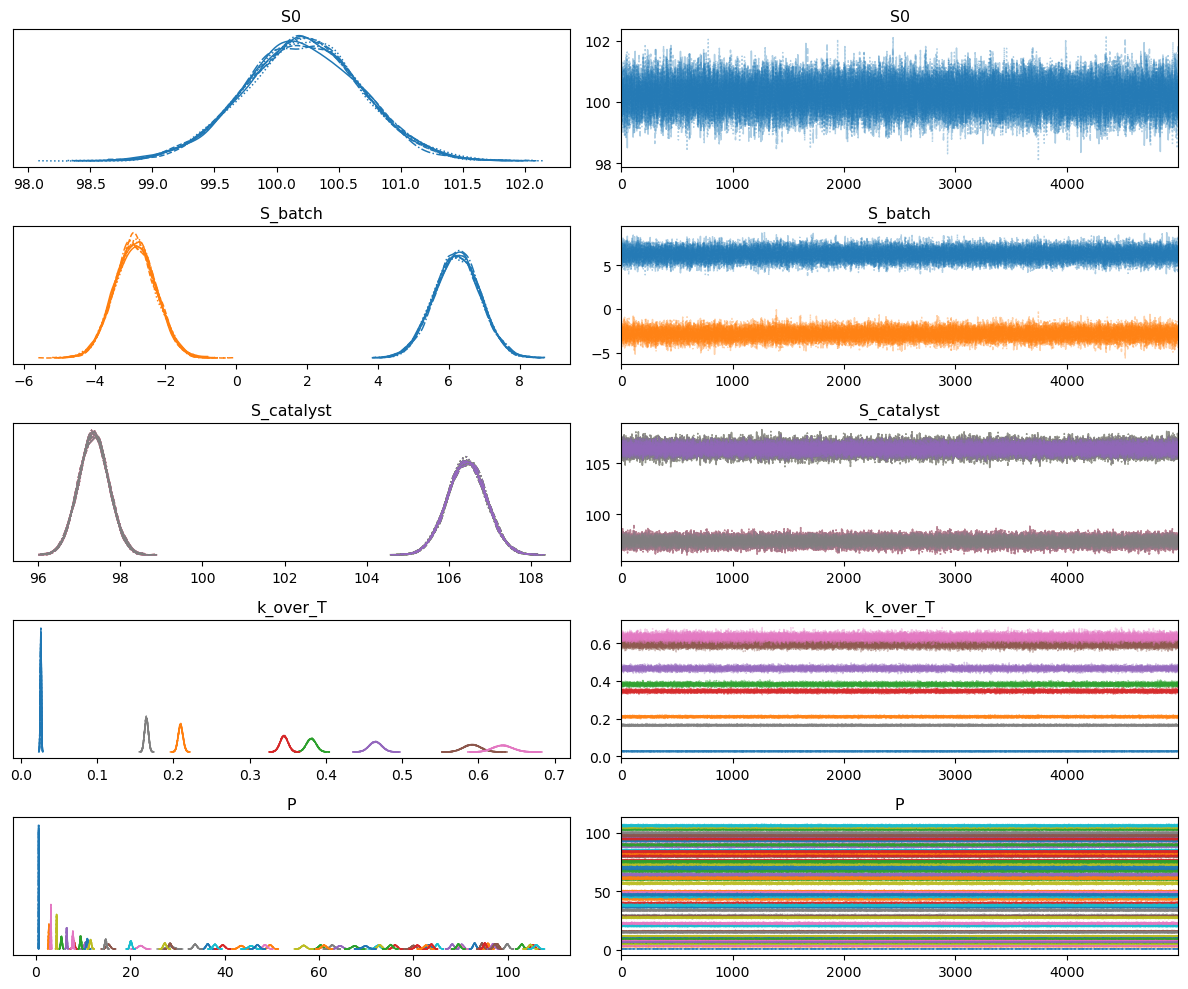

In [16]:
pm.plot_trace(
    trace2,
    var_names=[
        "S0", 
        "S_batch",
        "S_catalyst",
        "k_over_T",
        "P",
    ]
)
plt.tight_layout()

In [17]:
with pmodel2:
    # add the GP conditional to the model, given the new X values
    f_pred2 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace2.extend(pm.sample_posterior_predictive(trace2, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

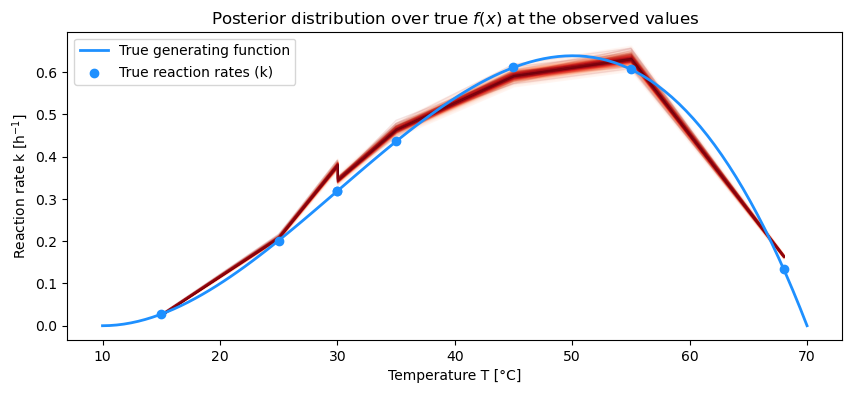

In [18]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
f_post2 = az.extract(trace2, var_names="k_over_T").transpose("sample", ...)
plot_gp_dist(ax, f_post2, T_sampled[:, None])


# plot the data and the true latent function
# ax.plot(, f_true, "dodgerblue", lw=3, label="True generating function "f"")
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)


# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

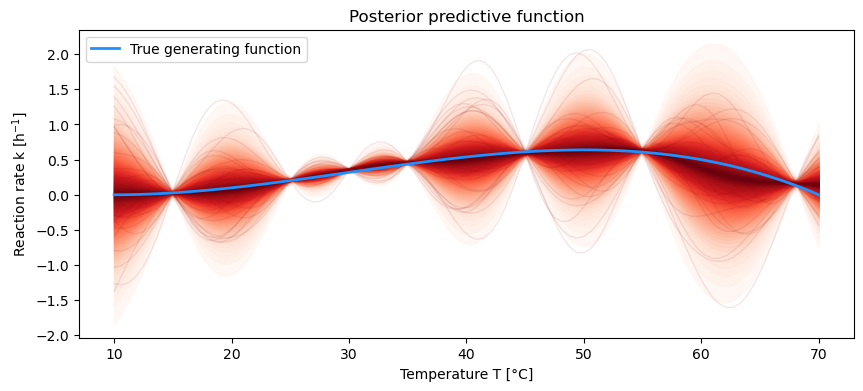

In [19]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred2, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

We can see how the hybrid model can use the information of the batch effect and describe the relationship between reaction rate and temperature well. Let's compare this with a simple model that is using a GP directly on reaction rates calculated via regression.

## Compare to SOTA: Fit reaction rate via regression and use a GP

In this SOTA example, we just calculate the reaction rates using regression and then use a simple GP to fit the relationship with temperature.

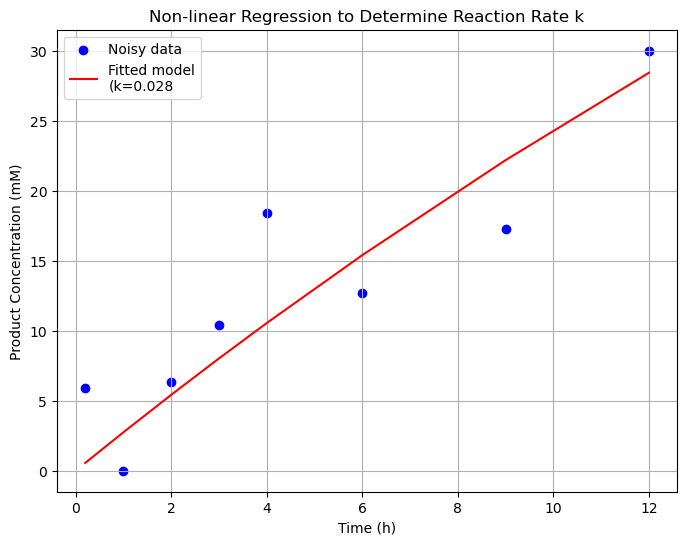

Estimated parameters:
k (reaction rate): 0.028 1/h


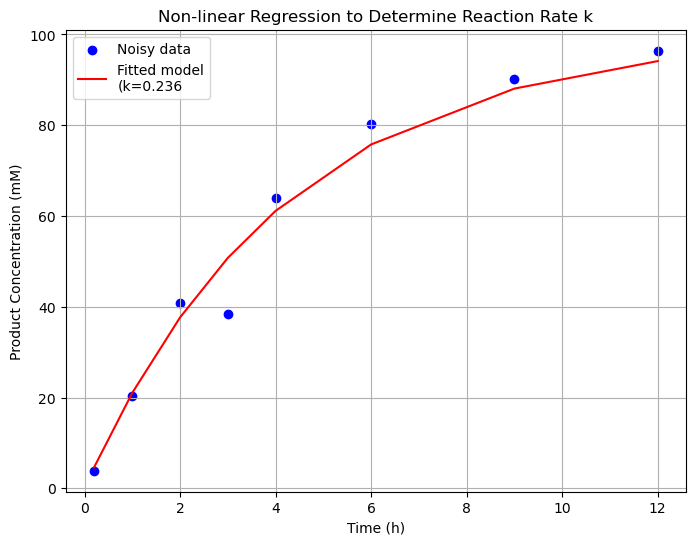

Estimated parameters:
k (reaction rate): 0.236 1/h


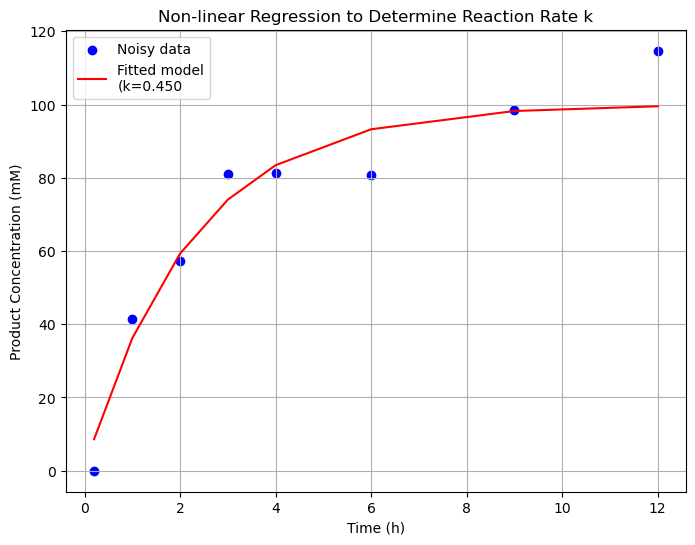

Estimated parameters:
k (reaction rate): 0.450 1/h


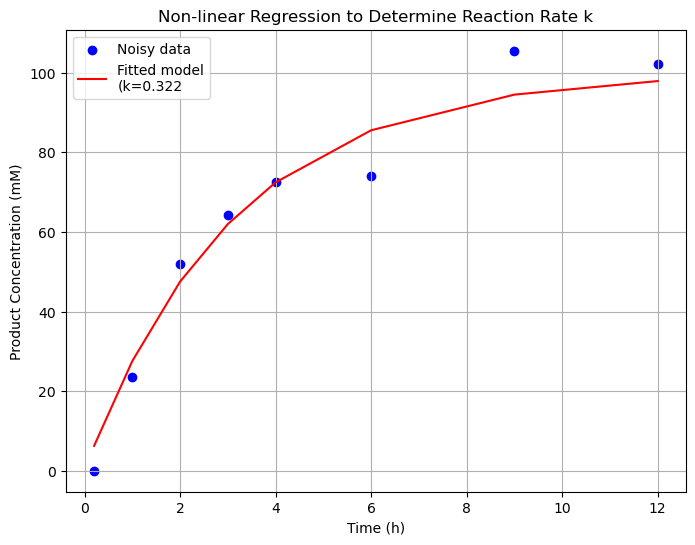

Estimated parameters:
k (reaction rate): 0.322 1/h


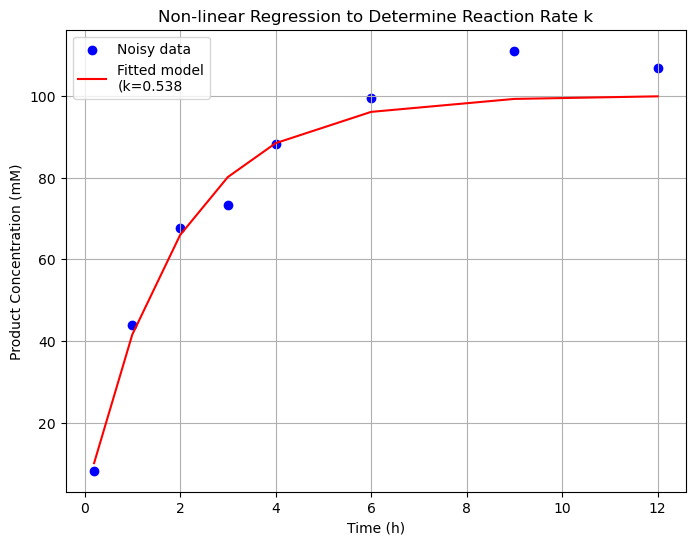

Estimated parameters:
k (reaction rate): 0.538 1/h


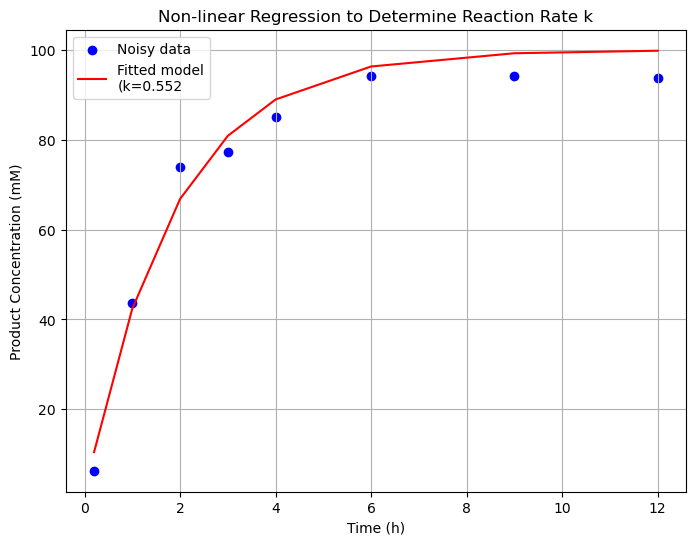

Estimated parameters:
k (reaction rate): 0.552 1/h


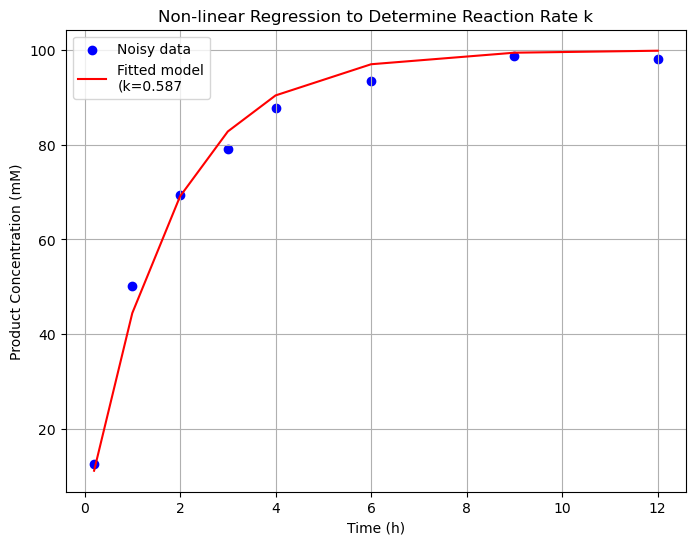

Estimated parameters:
k (reaction rate): 0.587 1/h


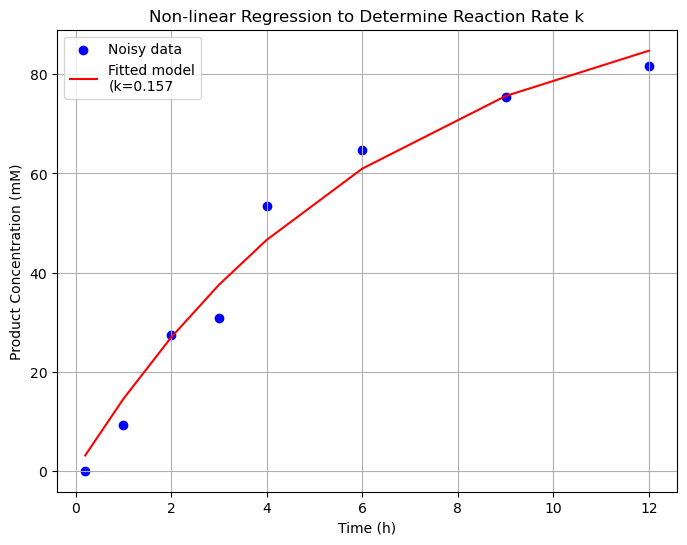

Estimated parameters:
k (reaction rate): 0.157 1/h


In [20]:
from scipy.optimize import curve_fit

# Function defining the mass-action model
def mass_action_model(t, k):
    return 100 * (1 - np.exp(-k * t))

k_estimated = []
for i in range(observed_bias.shape[0]):
    P_samples = observed_bias[i, :]
    # Perform non-linear regression
    initial_guess = [0.1]  # Initial guess for k
    popt, pcov = curve_fit(mass_action_model, time, P_samples, p0=initial_guess)

    # Extract optimized parameters
    k_fit = popt[0]

    k_estimated.append(k_fit)

    # Generate fitted curve
    P_fitted = mass_action_model(time, k_fit)

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.scatter(time, P_samples, label="Noisy data", color="blue")
    plt.plot(time, P_fitted, label=f"Fitted model\n(k={k_fit:.3f}", color="red")
    plt.xlabel("Time (h)")
    plt.ylabel("Product Concentration (mM)")
    plt.title("Non-linear Regression to Determine Reaction Rate k")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated parameters:")
    print(f"k (reaction rate): {k_fit:.3f} 1/h")


In [21]:
coords = {
    "catalyst": np.arange(8),
}

with pm.Model(coords=coords) as pmodel3:
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst",
    )
    k_data = pm.Data(
        "k_estimated",
        value=k_estimated,
        dims="catalyst",
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", sigma=0.04)
    gp.marginal_likelihood(
        "likelihood",
        X=temp_data[:, None],
        y=k_data,
        sigma=sigma,
    )
    trace3 = pm.sample(5000, tune=1000, chains=8, cores=-1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [sigma]


Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 28 seconds.


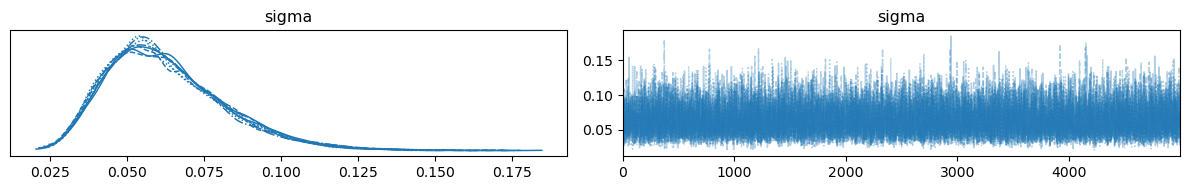

In [22]:
pm.plot_trace(trace3)
plt.tight_layout()

In [23]:
with pmodel3:
    # add the GP conditional to the model, given the new X values
    f_pred3 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace3.extend(pm.sample_posterior_predictive(trace3, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

### Bayesian optimization
Let's compare both models (hybrid model and simple GP) and visualize where we would design the next experiment to identify the optimum.

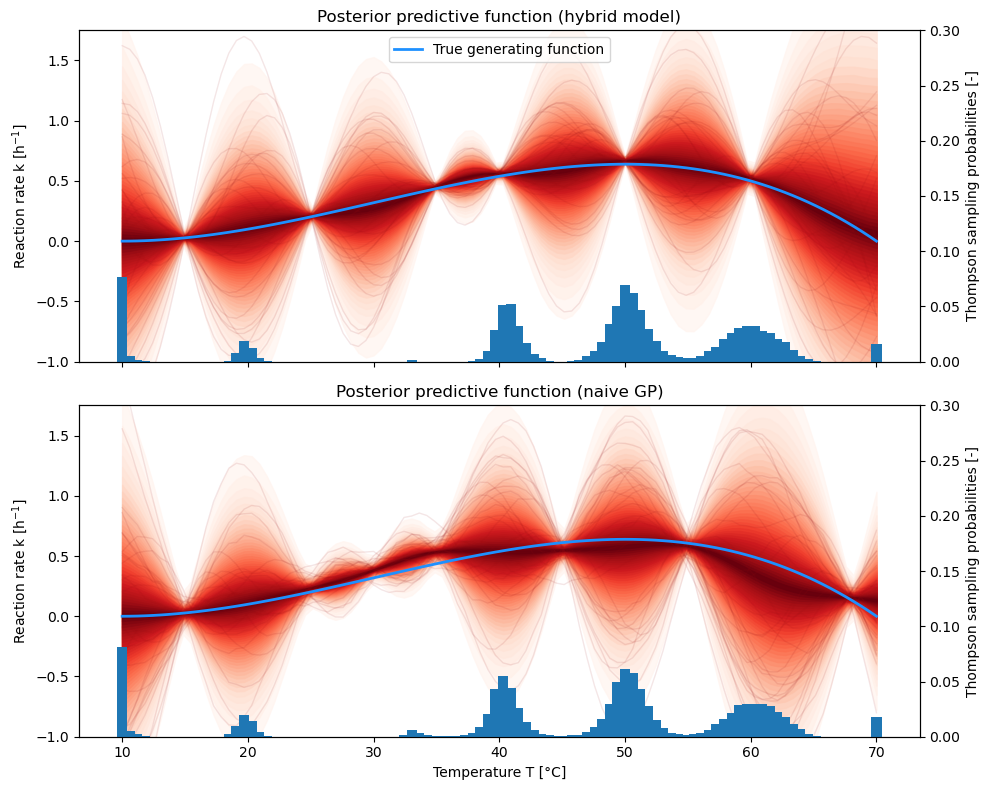

In [24]:
import pyrff

fig, axs = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)

ax = axs[0]
f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)

probs = pyrff.sampling_probabilities(trace2.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax2 = ax.twinx()
ax2.bar(T_full, probs)
ax2.set_ylim(0, 0.3)
ax2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (hybrid model)")
ax.legend(loc="upper center")
ax.set_ylim(-1, 1.75)

ax = axs[1]
f_pred3 = az.extract(trace3.posterior_predictive, var_names="f_pred").transpose("sample", ...)
probs = pyrff.sampling_probabilities(trace3.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax2 = ax.twinx()
ax2.bar(T_full, probs)
ax2.set_ylim(0, 0.3)
ax2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax, f_pred3, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (naive GP)")
ax.set_ylim(-1, 1.75)

plt.tight_layout()
plt.show()

## Final conclusions
We can see that it is more efficient to use a mechanistic equation for the reaction over time and to include the batch effect in the model.
In comparison, we will also find the optimum with a pure GP model over time, but it is less efficient for small datasets.

# Paper plot

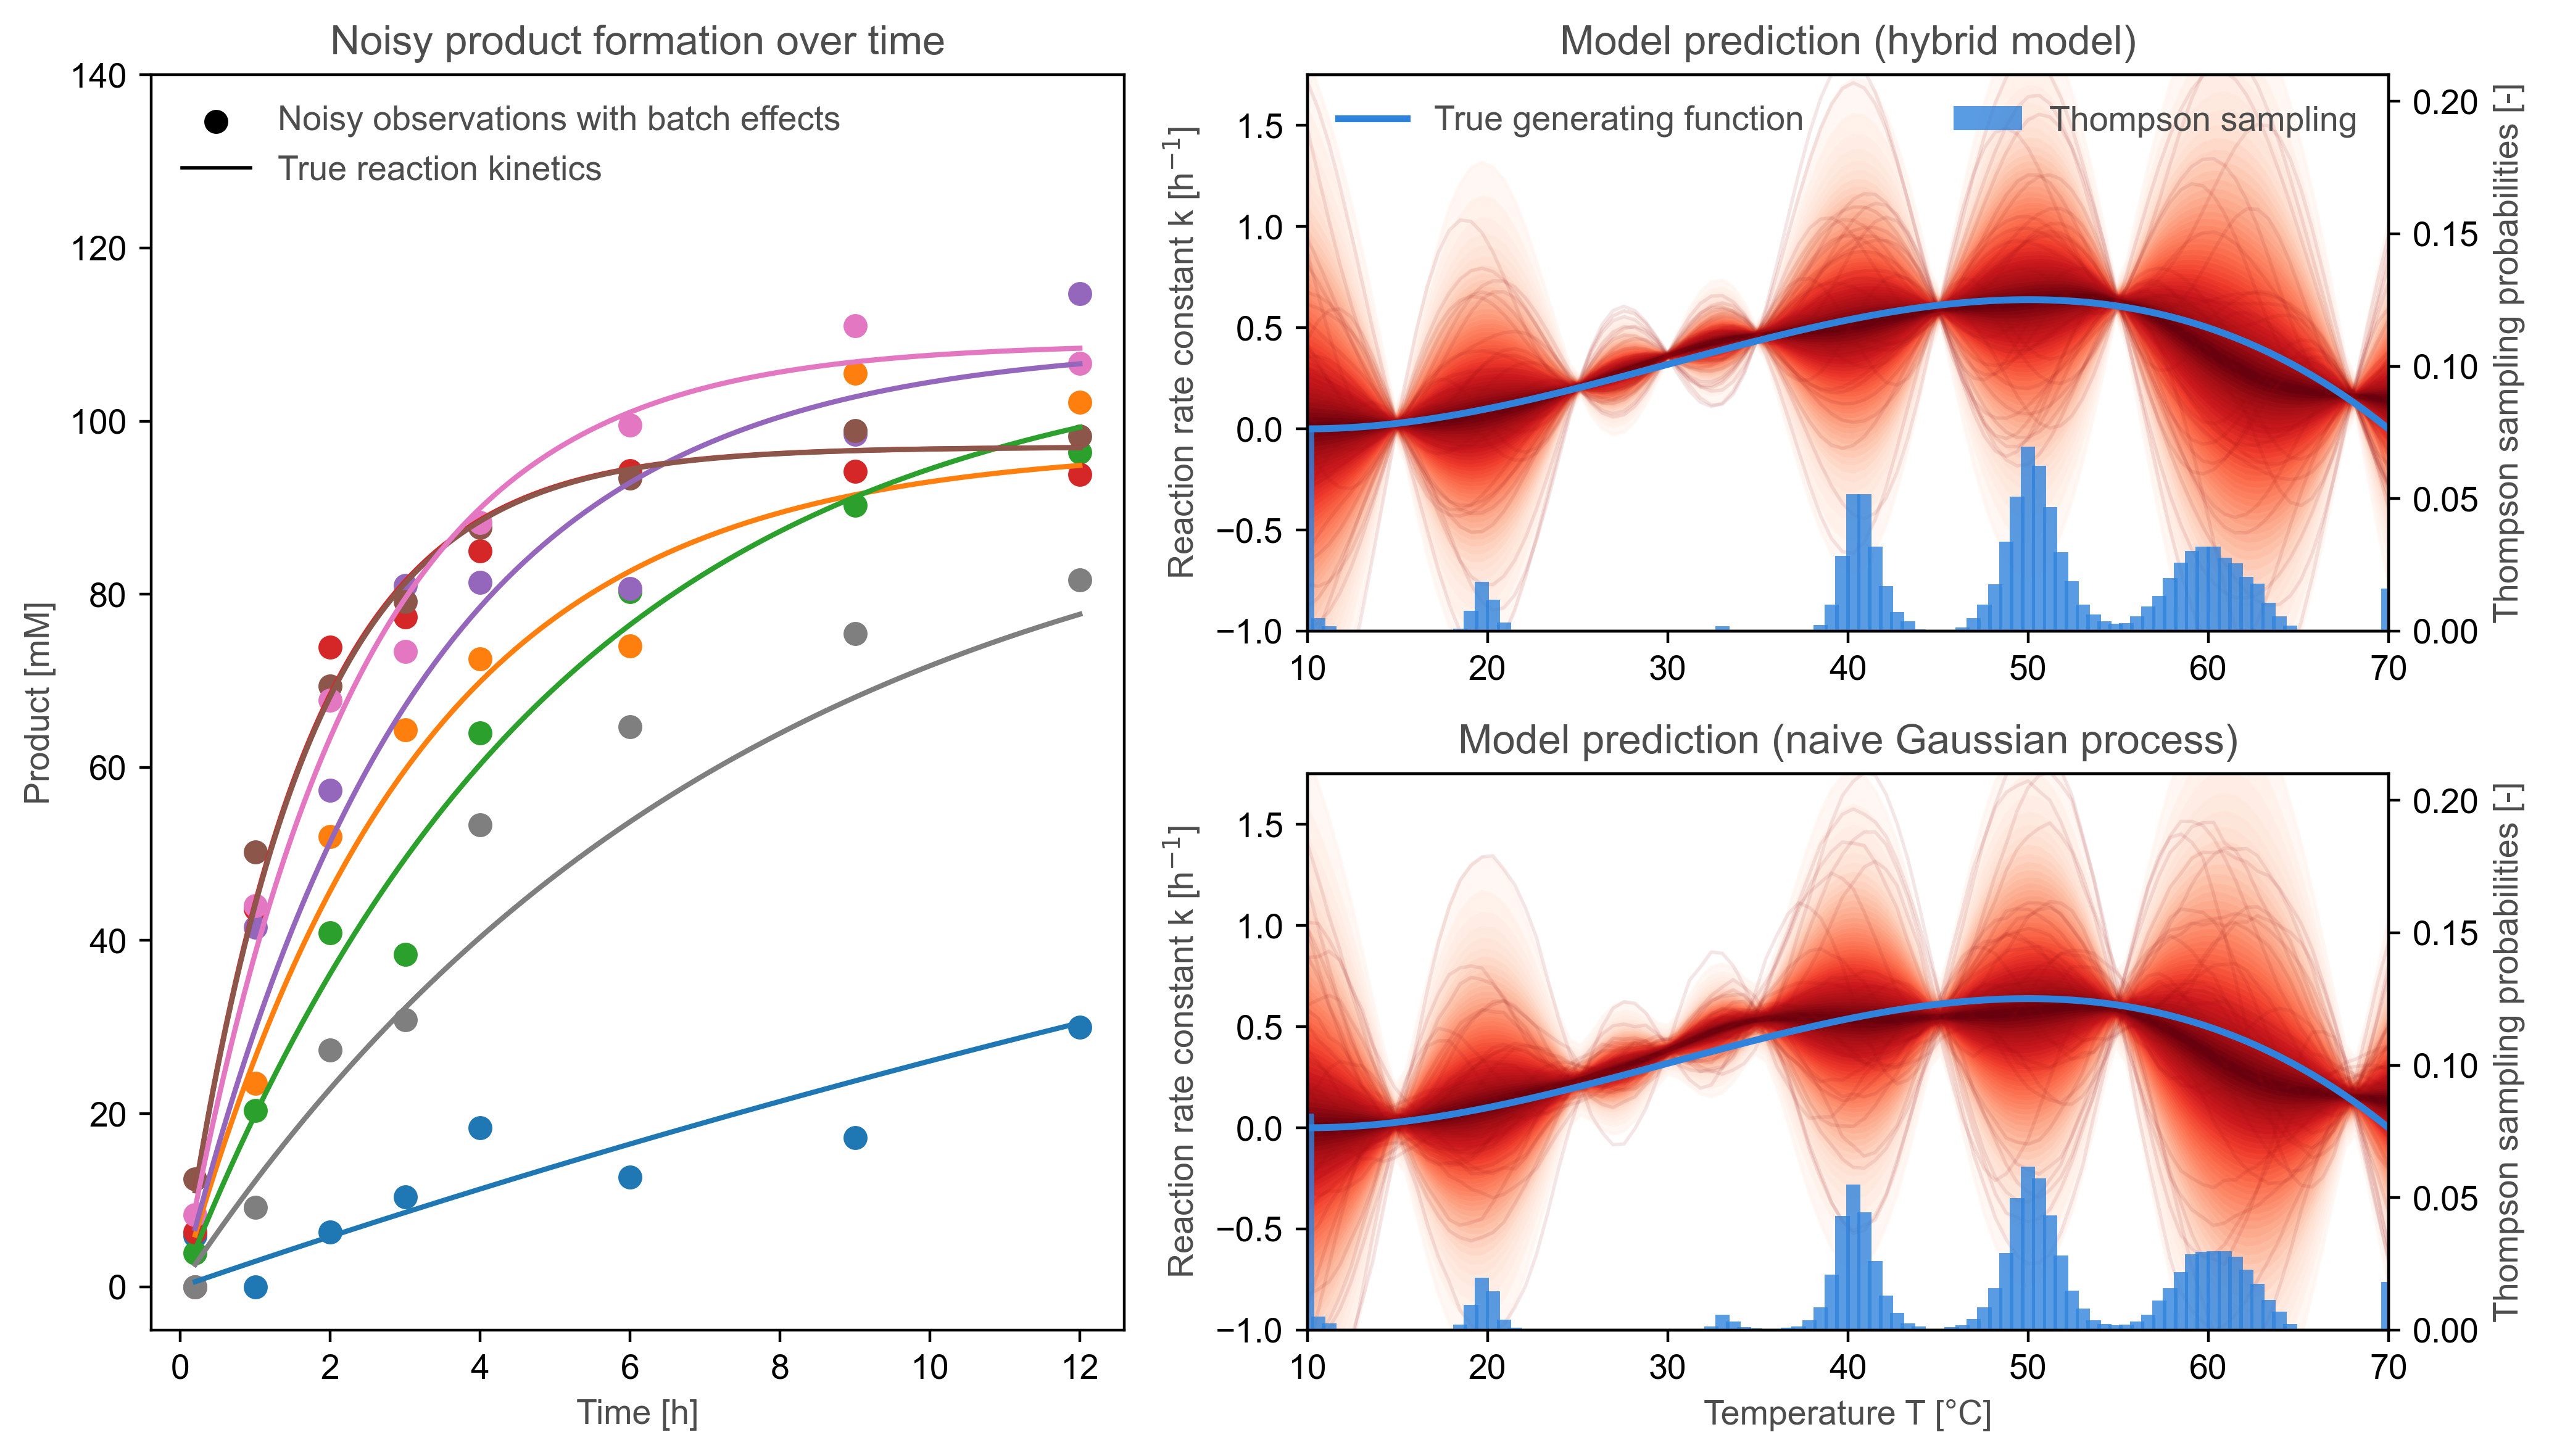

In [45]:
import matplotlib
from matplotlib.gridspec import GridSpec

matplotlib.rcParams["font.sans-serif"] = "Arial"
matplotlib.rcParams["font.family"] = "sans-serif"


class Colors:
    light_red = np.array((223, 83, 62)) / 255
    light_blue = np.array((69, 145, 247)) / 255
    dark_red = np.array((122, 25, 24)) / 255
    dark_blue = np.array((0, 0, 255)) / 255
    alt_blue = np.array((59, 117, 175)) / 255
    lavender = "#E6E6FA"
    magnolia = "#F4F0F7"
    gray = "#4D4D4D"
    current = "#00635D"
    eminence = "#713685"
    pink = "#E97DC3"
    green = "#08A238"
    taupe = "#8F564D"
    orange = "#FF8430"
    blue = "#3083DC"
    black = "k"


matplotlib.rcParams["text.color"] = Colors.gray
matplotlib.rcParams["axes.labelcolor"] = Colors.gray
matplotlib.rcParams["axes.titlecolor"] = Colors.gray
matplotlib.rcParams["xtick.color"] = Colors.black
matplotlib.rcParams["ytick.color"] = Colors.black

# Define the mosaic layout
fig = plt.figure(figsize=(15, 6), dpi=400)
gs = GridSpec(2, 3, width_ratios=[1.8, 2, 2], height_ratios=[1, 1], figure=fig)

# Big plot (left)
ax_left = fig.add_subplot(gs[:, 0])  # Span both rows in the left column

# Plot noisy product formation curves on the left
for (shaker, batch), data in df.groupby(["device", "batch"]):
    S0 = data.S0.values[0]
    t_data = data.time.values
    P_data = data.P_noisy.values
    k_value = data.k_true.values[0]
    temp = data.T_true.values[0]
    
    ax_left.scatter(t_data, P_data, marker="o")
    ax_left.plot(*(extract_high_res_P_series(
        time=t_data,
        k=k_value,
        S0=S0,
    )))
    # For simplified labels:
ax_left.scatter([], [], marker="o", color="black", label="Noisy observations with batch effects")
ax_left.plot([], [], color="black", linewidth=1, label="True reaction kinetics")


ax_left.set_title("Noisy product formation over time")
ax_left.set_xlabel("Time [h]")
ax_left.set_ylabel("Product [mM]")
ax_left.legend(loc="upper left", frameon=False)
ax_left.set_ylim(-5, 140)

# First subpanel (right, top)
ax1 = fig.add_subplot(gs[0, 1])
ax1_2 = ax1.twinx()
f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
probs = pyrff.sampling_probabilities(trace2.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax1_2.bar(T_full, probs, alpha=0.8, color=Colors.blue, label="Thompson sampling")
ax1_2.set_ylim(0, 0.21)
ax1_2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax1, f_pred2, T_full[:, None])
ax1_2.legend(loc="upper right", frameon=False)
ax1.plot(T_full, k_full, color=Colors.blue, label="True generating function", linewidth=2)
ax1.set_ylabel("Reaction rate constant k [h$^{-1}$]")
ax1.set_title("Model prediction (hybrid model)")
ax1.legend(loc="upper left", frameon=False)
ax1.set_ylim(-1, 1.75)
ax1.set_xlim(10, 70)


# Second subpanel (right, bottom)
ax2 = fig.add_subplot(gs[1, 1])
ax2_2 = ax2.twinx()
f_pred3 = az.extract(trace3.posterior_predictive, var_names="f_pred").transpose("sample", ...)
probs = pyrff.sampling_probabilities(trace3.posterior_predictive["f_pred"].stack(sample=("chain", "draw")), correlated=True)
ax2_2.bar(T_full, probs, alpha=0.8, color=Colors.blue)
ax2_2.set_ylim(0, 0.21)
ax2_2.set_ylabel("Thompson sampling probabilities [-]")
plot_gp_dist(ax2, f_pred3, T_full[:, None])
ax2.plot(T_full, k_full, color=Colors.blue, label="True generating function", linewidth=2)
ax2.set_xlabel("Temperature T [°C]")
ax2.set_ylabel("Reaction rate constant k [h$^{-1}$]")
ax2.set_title("Model prediction (naive Gaussian process)")
ax2.set_ylim(-1, 1.75)
ax2.set_xlim(10, 70)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("Figure3.pdf", dpi=300, bbox_inches="tight")
plt.show()